In [22]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


In [23]:
import argparse
import os.path as osp

import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.datasets import UPFD
from torch_geometric.data import DataLoader
from torch_geometric.transforms import ToUndirected
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, global_max_pool, global_mean_pool
from torch_geometric.nn import GINConv, global_add_pool,GINEConv
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU

In [38]:
path = osp.join(osp.dirname(osp.realpath("/content/tutorial1")), '..', 'data', 'UPFD')
train_dataset = UPFD(path, 'gossipcop', 'profile', 'train', ToUndirected())
val_dataset = UPFD(path, 'gossipcop', 'profile', 'val', ToUndirected())
test_dataset = UPFD(path, 'gossipcop', 'profile', 'test', ToUndirected())

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [39]:
print(val_dataset)

UPFD(546, name=gossipcop, feature=profile)


In [40]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, dim, out_channels):
        super(Net, self).__init__()

        self.conv1 = GINConv(
            Sequential(Linear(in_channels, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.conv2 = GINConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.conv3 = GINConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.conv4 = GINConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.conv5 = GINConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)
        x = self.conv4(x, edge_index)
        x = self.conv5(x, edge_index)
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(train_dataset.num_features, 180, train_dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(loader):
    model.eval()

    total_correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        total_correct += int((out.argmax(-1) == data.y).sum())
    return total_correct / len(loader.dataset)




In [41]:
loss = []
train_acc = []
test_acc = []

for epoch in range(1, 101):
    loss.append(train())
    train_acc.append(test(train_loader))
    test_acc.append(test(test_loader))
    print(f'Epoch: {epoch:03d}, Loss: {loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f} '
          f'Test Acc: {test_acc[-1]:.4f}')

Epoch: 001, Loss: 1.0289, Train Acc: 0.8013 Test Acc: 0.7974
Epoch: 002, Loss: 0.6276, Train Acc: 0.8196 Test Acc: 0.8173
Epoch: 003, Loss: 0.4928, Train Acc: 0.8462 Test Acc: 0.8244
Epoch: 004, Loss: 0.4356, Train Acc: 0.8462 Test Acc: 0.8246
Epoch: 005, Loss: 0.3701, Train Acc: 0.8617 Test Acc: 0.8403
Epoch: 006, Loss: 0.3411, Train Acc: 0.8883 Test Acc: 0.8709
Epoch: 007, Loss: 0.3053, Train Acc: 0.9075 Test Acc: 0.8725
Epoch: 008, Loss: 0.2579, Train Acc: 0.9277 Test Acc: 0.8939
Epoch: 009, Loss: 0.2926, Train Acc: 0.9020 Test Acc: 0.8693
Epoch: 010, Loss: 0.2826, Train Acc: 0.9148 Test Acc: 0.8868
Epoch: 011, Loss: 0.2472, Train Acc: 0.9194 Test Acc: 0.8847
Epoch: 012, Loss: 0.2486, Train Acc: 0.8938 Test Acc: 0.8662
Epoch: 013, Loss: 0.2448, Train Acc: 0.9240 Test Acc: 0.8928
Epoch: 014, Loss: 0.2621, Train Acc: 0.9267 Test Acc: 0.8902
Epoch: 015, Loss: 0.2705, Train Acc: 0.9231 Test Acc: 0.8871
Epoch: 016, Loss: 0.2203, Train Acc: 0.9368 Test Acc: 0.8931
Epoch: 017, Loss: 0.2301

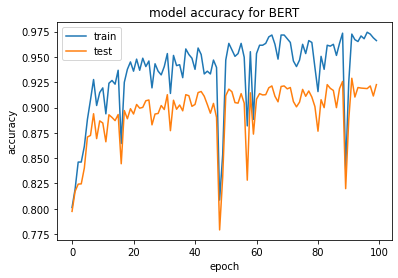

In [42]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(train_acc)
plt.plot(test_acc)
plt.title('model accuracy for BERT')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

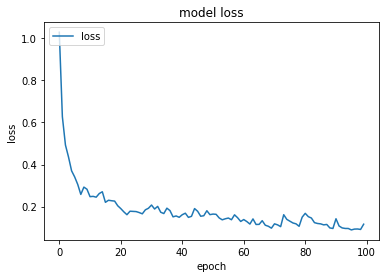

In [43]:

import matplotlib.pyplot as plt

plt.plot(loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()